<a href="https://colab.research.google.com/github/AlexBorealis/Unet_darkside/blob/master/Unet_darkside_main_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Best model**
https://drive.google.com/file/d/1sqrLAKwKTJjveox7cNaoCawMa7msZ0nZ/view?usp=sharing

# **Loading packages and suppress warnings**

In [ ]:
import warnings

warnings.filterwarnings('ignore')

***utils file must be downloaded from repository***

In [ ]:
import matplotlib
import gc
import os

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import regex as re
import utils as u

import tensorflow as tf
from typing import Union, Tuple
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import dice
from tensorflow.keras.metrics import IoU
from tensorflow.keras.callbacks import (
        EarlyStopping, ModelCheckpoint, TensorBoard,
        ReduceLROnPlateau, CSVLogger)

2025-01-14 06:01:36.240121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736834496.354707     160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736834496.384988     160 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 06:01:36.584347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Setting working directory**

In [ ]:
os.chdir('/workspace/darkside_test')

In [ ]:
os.getcwd()

'/workspace/darkside_test'

# **Loading datasets (train)**

In [ ]:
# !wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/dark-side/dark-side-train-data-part3.zip

# !mkdir -p dark-side-train-data-part3
# !unzip -o dark-side-train-data-part3.zip -d dark-side-train-data-part3

# **Loading datasets (test)**

In [ ]:
# !wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/dark-side/dark-side-test-data-part-3.zip

# !mkdir -p dark-side-test-data-part-3
# !unzip -o dark-side-test-data-part-3.zip -d dark-side-test-data-part-3

# **Creation names of variables**

In [ ]:
name_training_dataset = "dark-side-train-data-part3"
name_test_dataset = "dark-side-test-data-part-3"

# **Getting names of subfolders with training data**

In [ ]:
training_data = u.get_folders(name_training_dataset)
print('Sample IDs: ', training_data[:5])

Sample IDs:  ['2023-10-05_2fc32877', '2023-10-05_2ab65692', '2023-10-05_2c66f5af', '2023-10-05_1fc32f42', '2023-10-05_2013ccfd']


# **Creation plots of training data**

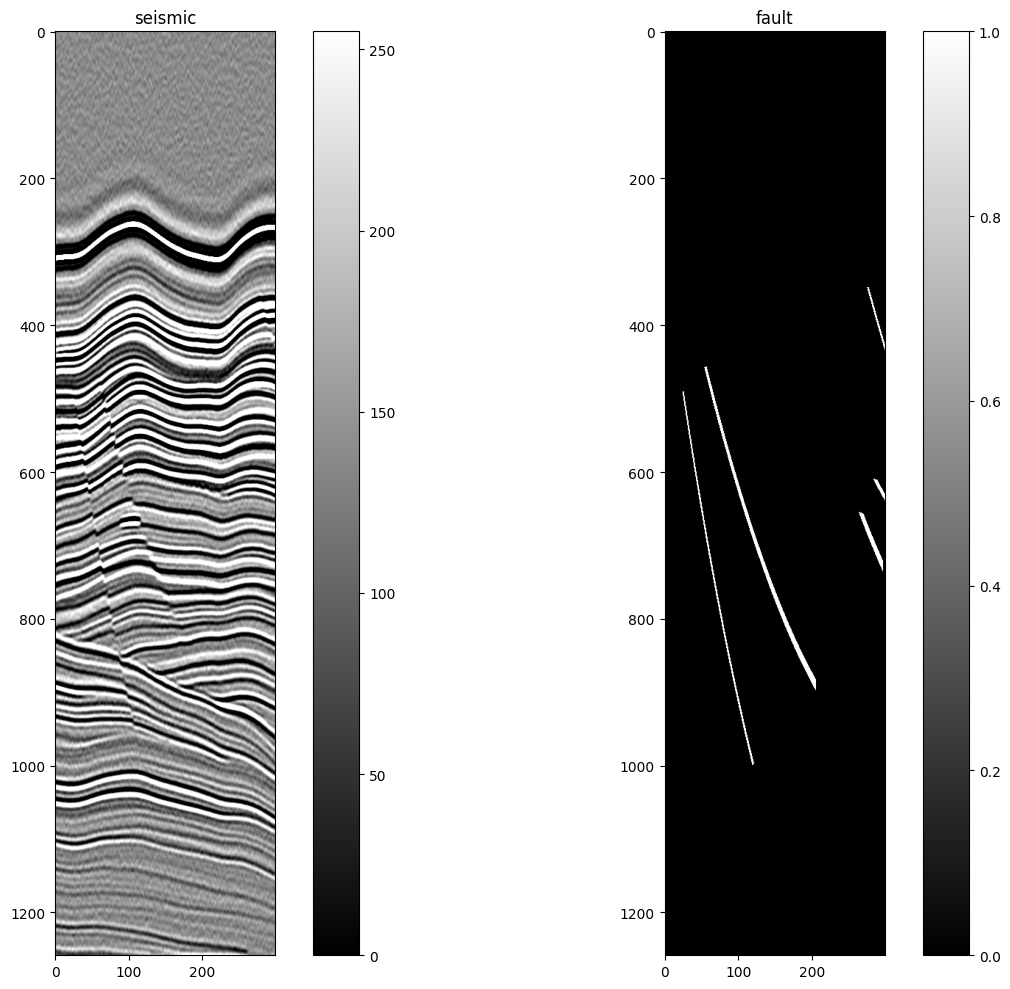

In [ ]:
seismic_train = u.get_cubes(name_training_dataset, training_data[1], 'seismic')
fault_train = u.get_cubes(name_training_dataset, training_data[1], 'fault')

slice_index = 100

fig, ax = plt.subplots(1, 2, figsize= (14, 10))

im1 = ax[0].imshow(u.rescale_volume(seismic_train, low= 10, high= 90)[slice_index, ...].T, cmap= "gray")
ax[0].set_title("seismic")
fig.colorbar(im1, ax=ax[0], orientation= "vertical")

# Plot the second image with a colorbar
im2 = ax[1].imshow(fault_train[slice_index, ...].T, cmap= "gray")
ax[1].set_title("fault")
fig.colorbar(im2, ax=ax[1], orientation="vertical")

plt.tight_layout()
plt.show()

# **Creation function of Unet network**

In [ ]:
def get_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(shape=img_size + (1,), name='unet_model')

    x = tf.keras.layers.Conv3D(16, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("leaky_relu")(x)

    x1 = tf.keras.layers.Conv3D(32, 3, padding="same")(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation("leaky_relu")(x1)

    x2 = tf.keras.layers.Conv3D(64, 3, padding="same")(x1)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.MaxPooling3D(2, padding="same")(x2)

    residual1 = tf.keras.layers.Conv3D(64, 3, padding="same", strides=2)(x)
    residual1 = tf.keras.layers.BatchNormalization()(residual1)
    residual1 = tf.keras.layers.Activation("leaky_relu")(residual1)
    x2 = tf.keras.layers.add([x2, residual1])

    x3 = tf.keras.layers.Conv3D(128, 3, padding="same")(x2)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.MaxPooling3D(2, padding="same")(x3)

    residual2 = tf.keras.layers.Conv3D(128, 3, padding="same", strides=2)(x2)
    residual2 = tf.keras.layers.BatchNormalization()(residual2)
    residual2 = tf.keras.layers.Activation("leaky_relu")(residual2)
    x3 = tf.keras.layers.add([x3, residual2])

    x4 = tf.keras.layers.Conv3D(256, 3, padding="same")(x3)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.MaxPooling3D(2, padding="same")(x4)

    residual3 = tf.keras.layers.Conv3D(256, 3, padding="same", strides=2)(x3)
    residual3 = tf.keras.layers.BatchNormalization()(residual3)
    residual3 = tf.keras.layers.Activation("leaky_relu")(residual3)
    x4 = tf.keras.layers.add([x4, residual3])

    x5 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x4)
    x5 = tf.keras.layers.Conv3D(256, 3, padding="same")(x5)
    x5 = tf.keras.layers.BatchNormalization()(x5)
    x5 = tf.keras.layers.Activation("leaky_relu")(x5)

    x6 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x5)
    x6 = tf.keras.layers.Conv3D(128, 3, padding="same")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Activation("leaky_relu")(x6)

    x7 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x6)
    x7 = tf.keras.layers.Conv3D(64, 3, padding="same")(x7)
    x7 = tf.keras.layers.BatchNormalization()(x7)
    x7 = tf.keras.layers.Activation("leaky_relu")(x7)

    x8 = tf.keras.layers.Conv3D(32, 3, padding="same")(x7)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Activation("leaky_relu")(x8)

    x9 = tf.keras.layers.Conv3D(16, 3, padding="same")(x8)
    x9 = tf.keras.layers.BatchNormalization()(x9)
    x9 = tf.keras.layers.Activation("leaky_relu")(x9)

    x10 = tf.keras.layers.Cropping3D(cropping=((2, 2), (2, 2), (2, 3)))(x9)

    outputs = tf.keras.layers.Conv3D(num_classes, 3, activation="sigmoid", padding="same")(x10)

    model = tf.keras.Model(inputs, outputs, name='unet_model')
    return model

# **Creation "model/" directory**

In [ ]:
if not os.path.exists('model/'):
    os.mkdir('model/')

# **Testing if model's exists**

In [ ]:
if os.path.exists('model/') and len(os.listdir('model/')) > 0:
    models = [m for m in os.listdir('model/') if 'best_unet' in m]
    try:
        filtered_models = [
                    m for m in models
                    if float(re.findall(r'\d+\.\d+', m)[0]) < .99 and float(re.findall(r'\d+\.\d+', m)[1]) <= .95
                ]
        filtered_models.sort(key=lambda i: (-float(re.findall(r'\d.\d+', i)[1]), float(re.findall(r'\d.\d+', i)[0])))
    except:
        pass

    if filtered_models:
        model = tf.keras.models.load_model(os.path.join('model/', filtered_models[0]))
        print(filtered_models[0])
    else:
        print("No suitable models found.")
else:
    model = get_model((100, 100, 1259), 1)

    # Model compilation
    model.compile(optimizer= SGD(nesterov= True, momentum= .1, learning_rate= .005),
                  loss= dice,
                  metrics= [tf.metrics.IoU(num_classes= 2, target_class_ids= [0, 1])])

I0000 00:00:1736834506.853750     160 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


best_unet_model.dice_0.12-iou_0.79.h5.keras


In [ ]:
model.summary(show_trainable= True, expand_nested= True)

Model: "unet_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ unet_model        │ (None, 100,     │         0 │ -              │   -   │
│ (InputLayer)      │ 100, 1259, 1)   │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3d (Conv3D)   │ (None, 100,     │       448 │ unet_model[0]… │   Y   │
│                   │ 100, 1259, 16)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 100,     │        64 │ conv3d[0][0]   │   Y   │
│ (BatchNormalizat… │ 100, 1259, 16)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 100,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 100, 1259, 16)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3d_1 (Conv3D) │ (None, 100,     │    13,856 │ activation[0]… │   Y   │
│                   │ 100, 1259, 32)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 100,     │       128 │ conv3d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 100, 1259, 32)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 100,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 100, 1259, 32)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3d_2 (Conv3D) │ (None, 100,     │    55,360 │ activation_1[… │   Y   │
│                   │ 100, 1259, 64)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3d_3 (Conv3D) │ (None, 50, 50,  │    27,712 │ activation[0]… │   Y   │
│                   │ 630, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 100,     │       256 │ conv3d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 100, 1259, 64)  │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 50, 50,  │       256 │ conv3d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 630, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling3d     │ (None, 50, 50,  │         0 │ batch_normali… │   -   │
│ (MaxPooling3D)    │ 630, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 50, 50,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 630, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 50, 50,  │         0 │ max_pooling3d… │   -   │
│                   │ 630, 64)        │           │ activation_2[… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3d_4 (Conv3D) │ (None, 50, 50,  │   221,312 │ add[0][0]      │   Y   │
│                   │ 630, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3d_5 (Conv3D) │ (None, 25, 25,  │   221,312 │ add[0][0]      │   Y   │
│                   │ 315, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 50, 50,  │       512 │ conv3d_4[0][0] │   Y 

 Total params: 10,519,492 (40.13 MB)

 Trainable params: 5,258,305 (20.06 MB)

 Non-trainable params: 2,880 (11.25 KB)

 Optimizer params: 5,258,307 (20.06 MB)

In [ ]:
# !rm -rf ./logs
# !rm -rf ./model

# **Creation callbacks and names for its**

In [ ]:
tensorboard_logs_name = './logs_' + name_training_dataset
csv_logger_name = 'training_log_unet_' + name_training_dataset + '.csv'

# Callbacks
model_checkpoint = ModelCheckpoint('./model/best_unet_model.dice_{loss:.2f}-iou_{io_u:.2f}.h5.keras',
                                   mode= 'io_u',
                                   monitor= 'max')
tensorboard = TensorBoard(log_dir= tensorboard_logs_name)
early_stopping = EarlyStopping(monitor= "loss", mode= 'min',
                               patience= 50, start_from_epoch= 50,
                               min_delta= .01, verbose= 1)
csv_logger = CSVLogger(csv_logger_name, separator= ",", append= True)

# **Main training cycle**

In [ ]:
for td in training_data:
    seismic_train = u.get_cubes(name_training_dataset, td, 'seismic')
    fault_train = u.get_cubes(name_training_dataset, td, 'fault')

    print("\n Quantity marks of faults:", np.sum(fault_train))

    # Train models
    for i in range(0, 300, 100):
        for j in range(0, 300, 100):
            # Train
            model.fit(x= np.reshape(u.rescale_volume(seismic_train, low= 5, high= 95)[i:i+100, j:j+100, :], (1, 100, 100, 1259, 1)),
                      y= np.reshape(fault_train.astype('float32')[i:i+100, j:j+100, :], (1, 100, 100, 1259, 1)),
                      batch_size= 256,
                      epochs= 200,
                      callbacks= [model_checkpoint, tensorboard, early_stopping, csv_logger],
                      verbose= 0)

            models = [m for m in os.listdir('model/') if 'best_unet' in m]
            try:
                filtered_models = [
                    m for m in models
                    if float(re.findall(r'\d+\.\d+', m)[0]) < .99 and float(re.findall(r'\d+\.\d+', m)[1]) <= .95
                ]
                filtered_models.sort(key=lambda i: (-float(re.findall(r'\d.\d+', i)[1]), float(re.findall(r'\d.\d+', i)[0])))

                model = tf.keras.models.load_model(os.path.join('model/', filtered_models[0]))
                print(filtered_models[0])
            except:
                print("Default model")

    gc.collect()


 Quantity marks of faults: 87165


I0000 00:00:1736834570.858407     619 service.cc:148] XLA service 0x7fb9e42234b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736834570.858444     619 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-01-14 06:02:51.016400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736834571.310213     619 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1736834572.352071     619 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736834572.658476     619 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-14 06:02:54.720185: E external/l

Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-iou_0.79.h5.keras

 Quantity marks of faults: 391546
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
Epoch 101: early stopping
best_unet_model.dice_0.12-iou_0.79.h5.keras
best_unet_model.dice_0.12-i

# **Getting names of subfolders with testing data**

In [ ]:
test_data = u.get_folders(name_test_dataset)

print("Test Sample IDs:\n", test_data[:5])

Test Sample IDs:
 ['2023-10-05_94554270', '2023-10-05_9f7308ad', '2023-10-05_865ae126', '2023-10-05_8b32c36b', '2023-10-05_8dcd49d9']


# **Creation plots of data**

In [ ]:
seismic_test = u.rescale_volume(u.get_cubes(name_test_dataset, test_data[4], 'seismic'), low= 5, high= 95)

print(
    f"\n Seismic array is of the shape: {seismic_test.shape} and of the data type: {seismic_test.dtype}"
)


 Seismic array is of the shape: (300, 300, 1259) and of the data type: float64


# **Getting prediction on test data**

In [ ]:
fault_predicted = np.zeros((300, 300, 1259))

# Predict on test
for i in range(0, 300, 100):
    for j in range(0, 300, 100):
        # Test
        predict = model.predict(np.reshape(seismic_test[i:i+100, j:j+100, :], (1, 100, 100, 1259, 1)))
        predict = np.squeeze(predict)
        fault_predicted[i:i+100, j:j+100, :] = predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


# **Creation .npz archive with predictions**

In [ ]:
name_predicted = os.listdir(os.path.join('dark-side-test-data-part-3', test_data[4]))
name_predicted = re.sub(r'seismicCubes_RFC_fullstack_', 'fault_segments_', name_predicted[0])
name_predicted = re.sub(r'.npy', '', name_predicted)
name_predicted

u.create_submission(test_data[4], fault_predicted, name_predicted)

File not found, new submission will be created.


# **Creation plots of testing data and predictions**

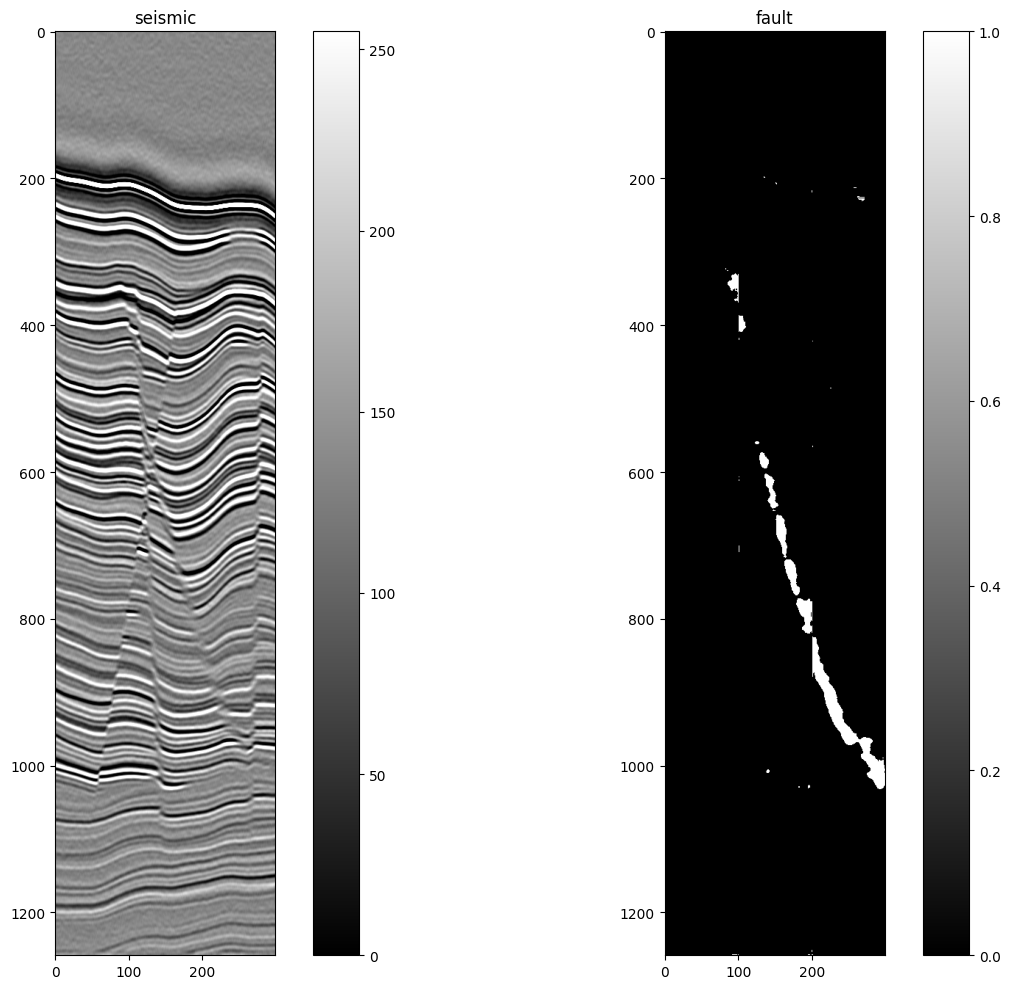

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (14, 10))

im1 = ax[0].imshow(seismic_test[slice_index, ...].T, cmap= "gray")
ax[0].set_title("seismic")
fig.colorbar(im1, ax=ax[0], orientation= "vertical")

# Plot the second image with a colorbar
im2 = ax[1].imshow(np.where(fault_predicted > 10**(-3), 1, 0)[slice_index, ...].T, cmap= "gray")
ax[1].set_title("fault")
fig.colorbar(im2, ax=ax[1], orientation="vertical")

plt.tight_layout()
plt.show()